# Исследование и оценка методов и архитектур на задаче детекции дорожных знаков

Код был взят из семинара по детекции курса DLS. Это модифицированная под RTSD версия

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import os
import math
import json
from functools import partial
from collections import Counter, defaultdict

import io
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.ops import nms, box_iou
from torchvision.models.detection.anchor_utils import AnchorGenerator

from torchmetrics.detection import MeanAveragePrecision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Подготовка данных

In [2]:
class_to_name = (
    "Главная дорога",
    "Опасный поворот",
    "Искусственная неровность",
    "Ограничение максимальной скорости",
    "Зона действия",
    "Пешеходный переход",
    "Место остановки автобуса",
    "Конец зоны ограничения максимальной скорости",
    "Стоп-линия",
    "Место стоянки такси",
    "Конец главной дороги",
    "Уступите дорогу",
    "Направление главной дороги",
    "Объезд препятствия справа",
    "Сужение дороги с обеих сторон",
    "Дорожные работы",
    "Движение грузовых автомобилей запрещено",
    "Направление действия",
    "Вид транспортного средства",
    "Движение направо или налево",
    "Объезд препятствия слева или справа",
    "Движение прямо",
    "Прочие опасности",
    "Конец полосы",
    "Остановка запрещена",
    "Скользкая дорога",
    "Направления движения на следующем перекрестке",
    "Место для разворота",
    "Расстояние до объекта",
    "Подземный пешеходный переход",
    "Начало полосы",
    "Автозаправочная станция",
    "Опасная обочина",
    "Парковка",
    "Платные услуги",
    "Неровная дорога",
    "Опасный поворот первый направо",
    "Надземный пешеходный переход",
    "Направления движения по полосам",
    "Больница",
    "Направления движения по полосе",
    "Пост дорожно-патрульной службы",
    "Поворот направо запрещен",
    "Конец дороги с односторонним движением",
    "Дорога с односторонним движением",
    "Техническое обслуживание автомобилей",
    "Движение направо",
    "Пункт питания",
    "Пешеходный переход",
    "Выброс гравия",
    "Примыкание второстепенной дороги",
    "Светофорное регулирование",
    "Ограничение высоты",
    "Пересечение с второстепенной дорогой",
    "Пункт контроля международных автомобильных перевозок",
    "Опасный поворот",
    "Опасные повороты первый налево",
    "Сужение дороги",
    "Опасные повороты",
    "Движение транспортных средств с опасными грузами запрещено",
    "Движение без остановки запрещено",
    "Въезд запрещен",
    "Направление движения транспортных средств с опасными грузами",
    "Обгон запрещен",
    "Движение механических транспортных средств запрещено",
    "Конец населенного пункта",
    "Направление движения к населенному пункту",
    "Мойка автомобилей",
    "Ограничение ширины",
    "Железнодорожный переезд без шлагбаума",
    "Сужение дороги слева",
    "Движение прямо или направо",
    "Телефон",
    "Круговое движение",
    "Движение прямо или налево",
    "Тоннель",
    "Движение пешеходов запрещено",
    "Объезд препятствия слева",
    "Пункт медицинской помощи",
    "Стоянка запрещена",
    "Движение налево",
    "Конец дороги с полосой для маршрутных транспортных средств",
    "Дорога для автомобилей",
    "Тупик",
    "Конец зоны всех ограничений",
    "Рекомендуемая скорость",
    "Двустороннее движение",
    "Конец зоны запрещения обгона",
    "Крутой спуск",
    "Крутой подъем",
    "Пересечение с круговым движением",
    "Разворот запрещен",
    "Преимущество встречного движения",
    "Преимущество перед встречным движением",
    "Время действия",
    "Полоса для маршрутных транспортных средств",
    "Жилая зона",
    "Железнодорожный переезд со шлагбаумом",
    "Направление движения для грузовых автомобилей",
    "Способ постановки транспортного средства на стоянку",
    "Слепые пешеходы",
    "Пешеходная дорожка",
    "Ограничение массы",
    "Инвалиды",
    "Стоянка запрещена по четным числам месяца",
    "Выезд на дорогу с полосой для маршрутных транспортных средств",
    "Пересечение с трамвайной линией",
    "Стоянка запрещена по нечетным числам месяца",
    "Ограничение минимальной дистанции",
    "Низколетящие самолеты",
    "Дорога с полосой для велосипедистов",
    "Пересечение равнозначных дорог",
    "Ограничение массы, приходящейся на ось транспортного средства",
    "Реверсивное движение",
    "Полоса движения",
    "Таможня",
    "Движение тракторов запрещено",
    "Перегон скота",
    "Велосипедная дорожка",
    "Выезд на набережную",
    "Влажное покрытие",
    "Общественный телефон",
    "Пункт контроля транспортных средств",
    "Фотовидеофиксация"
)

In [3]:
dataset_path = "/kaggle/input/rtsd-small/"
anno_path = dataset_path + "/full_gt_reduced.csv"
image_dir = dataset_path + "/rtsd-dataset-reduced/rtsd-dataset-reduced/rtsd-frames"
label_map = dataset_path + "/rtsd-dataset-reduced/rtsd-dataset-reduced/label_map.json"

with open(label_map, 'r') as f:
    label_map = json.load(f)
    label_map = {k: v - 1 for k, v in label_map.items()}
    label_map_reverse = {v: k for k, v in label_map.items()}

class_to_color = [tuple(np.random.choice(range(256), size=3)) for _ in range(len(label_map))]

df = pd.read_csv(anno_path)

# Временно отфильтруем классы по label_map
# single_class = ("6_16", )
df = df[df["sign_class"].isin(label_map.keys())]

df['bboxes'] = df[['x_from', 'y_from', 'width', 'height']].apply(lambda row: [row['x_from'], row['y_from'], row['width'], row['height']], axis=1)

df['sign_class'] = df[['sign_class']].apply(lambda row: label_map[row['sign_class']], axis=1)

df = df.drop(
    columns=["Unnamed: 0", "is_train", 'x_from', 'y_from', 'width', 'height', "sign_id"],
    errors="ignore"
).rename(columns={"sign_class": "labels"})

# Группируем разметку разных знаков в одну запись
df = df.groupby('filename').agg({
    'labels': lambda x: list(x),
    'bboxes': lambda x: list(x)
}).reset_index()

In [4]:
from skmultilearn.model_selection import IterativeStratification

def stratified_train_test_split(df, test_size=0.3, random_state=None):
    # Create multi-hot encoded labels
    all_sign_ids = sorted(set(sign_id for sublist in df['labels'] for sign_id in sublist))
    y = np.zeros((len(df), len(all_sign_ids)), dtype=int)
    
    for i, sign_ids in enumerate(df['labels']):
        for sign_id in sign_ids:
            col_idx = all_sign_ids.index(sign_id)
            y[i, col_idx] = 1

    stratifier = IterativeStratification(
        n_splits=2,
        order=1,
        sample_distribution_per_fold=[1-test_size, test_size],
        random_state=random_state
    )
    test_indices, train_indices = next(stratifier.split(df.index.values, y))

    return df.iloc[train_indices], df.iloc[test_indices]

def verify_stratification(df_train, df_test):
    # Count class occurrences
    all_sign_ids = sorted(set(sign_id for sublist in pd.concat([df_train, df_test])['labels'] 
                          for sign_id in sublist))
    
    results = []
    for sign_id in all_sign_ids:
        train_count = sum(sign_id in signs for signs in df_train['labels'])
        test_count = sum(sign_id in signs for signs in df_test['labels'])
        total = train_count + test_count
        
        if total > 0:
            train_pct = (train_count / total) * 100
            test_pct = (test_count / total) * 100
            results.append((sign_id, f"{train_pct:.1f}% / {test_pct:.1f}%", train_count, test_count))
    
    # Create comparison report
    report = pd.DataFrame(results, 
                         columns=['labels', 'train% / test%', 'train_count', 'test_count'])
    
    print("Stratification Verification Report:")
    print(report.to_string(index=False))
    print("\nKey:")
    print("- Proportions show how each class's instances were divided between train/test")
    print("- Perfect stratification would match the original split ratio (e.g., 70%/30%)")

In [5]:
df_train, df_test = stratified_train_test_split(df, test_size=0.3, random_state=None)

In [6]:
print(df_train.shape)
df_train.head()

(1649, 3)


filename           labels  \
1  autosave01_02_2012_09_16_50.jpg             [10]   
3  autosave01_02_2012_09_16_56.jpg             [11]   
4  autosave01_02_2012_09_17_01.jpg         [11, 12]   
5  autosave01_02_2012_09_17_04.jpg         [12, 13]   
8  autosave01_02_2012_09_17_09.jpg  [12, 13, 6, 14]   

                                              bboxes  
1                               [[937, 210, 59, 72]]  
3                               [[720, 315, 31, 31]]  
4           [[768, 296, 39, 36], [730, 308, 16, 19]]  
5           [[747, 285, 20, 23], [751, 315, 22, 24]]  
8  [[825, 99, 48, 52], [840, 175, 45, 47], [1104,...

Создаем датасет для предобработки данных

In [7]:
class RTSDDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.image_dir = image_dir
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        labels: List[int] Набор классов для каждого ббокса,
        boxes: List[List[int]] Набор ббоксов в формате (x_min, y_min, w, h).
        """
        row = self.data.iloc[idx]
        image_name = row['filename']
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        image = np.array(image)  # uint8 (0-255) HWC формат

        target = {}
        target["image_id"] = idx

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=row["bboxes"], labels=row["labels"])
            image, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        # Get dimensions (works for both tensor and numpy)
        if isinstance(image, torch.Tensor):
            _, h, w = image.shape
        else:
            h, w = image.shape[:2]

        # Нормализуем координаты ббоксов к [0, 1]
        # normalized_bboxes = []

        # for bbox in boxes:
        #     x_min, y_min, width, height = bbox

        #     # Normalize coordinates
        #     x_min_norm = x_min / w
        #     y_min_norm = y_min / h
        #     width_norm = width / w
        #     height_norm = height / h

        #     normalized_bboxes.append([x_min_norm, y_min_norm, width_norm, height_norm])

        # normalized_bboxes = np.array(normalized_bboxes, dtype=np.float32)
        
        # boxes = normalized_bboxes
        target['boxes'] = torch.tensor(np.array(boxes), dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)

        return image, target

def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

In [8]:
def compute_dataset_statistics(dataset, batch_size=16):
    """Compute mean and std of dataset in 0-255 range"""
    loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))  # Simple collate for images
    )
    
    channel_sum = np.zeros(3)
    channel_sq_sum = np.zeros(3)
    total_pixels = 0
    
    for batch in tqdm(loader, desc="Computing statistics"):
        images = batch[0]  # List of numpy images (H, W, 3)

        images = list(images)
        for i in range(len(images)):
            # Convert to tensor if not already
            if not isinstance(images[i], torch.Tensor):
                # Convert numpy (H,W,C) to tensor (C,H,W)
                images[i] = torch.from_numpy(images[i]).permute(2, 0, 1).float()

        # Stack images and convert to float64 for precision
        batch_array = np.stack(images).astype(np.float32)
        batch_array = np.transpose(batch_array, (0, 2, 3, 1))
        b, h, w, c = batch_array.shape
        
        # Sum across batch and spatial dimensions
        channel_sum += batch_array.sum(axis=(0, 1, 2))
        channel_sq_sum += (batch_array ** 2).sum(axis=(0, 1, 2))
        total_pixels += b * h * w

    # Calculate final statistics
    mean = channel_sum / total_pixels
    std = np.sqrt(channel_sq_sum / total_pixels - mean ** 2)
    
    return mean.tolist(), std.tolist()

In [9]:
# stats_transform = A.Compose([
#     A.Resize(height=img_height, width=img_width),
#     # ToTensorV2()
# ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

# # Create dataset for statistics
# stats_dataset = RTSDDataset(
#     df_train,  # Use full training data
#     image_dir,
#     transform=stats_transform
# )

In [10]:
# mean, std = compute_dataset_statistics(stats_dataset)
# mean = np.array(mean) / 255
# std = np.array(std) / 255

# print(f"Mean: {mean}")
# print(f"Std:  {std}")

In [11]:
img_width = 640
img_height = 640

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.Resize(height=img_height, width=img_width),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

test_transform = A.Compose([
    A.Resize(height=img_height, width=img_width),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

In [40]:
batch_size = 2

train_dataset = RTSDDataset(df_train[:20], image_dir, transform=train_transform)
test_dataset = RTSDDataset(df_test[:10], image_dir, transform=test_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Посмотрим на некоторые статистики по датасету

In [13]:
def train_info(train_dataloader):
    """ Считаем статистики по датасету и рисуем распределение размеров ббоксов по классам. """
    image_min_box_count, image_max_box_count, image_mean_box_count = float('inf'), 0, 0
    total_box_count = 0
    total_image_count = 0
    objects_per_class = {k: 0 for k, v in label_map_reverse.items()}
    bboxes_sizes = defaultdict(list)
    labels = set()
    for images, targets in tqdm(train_dataloader, desc="Train Dataset Info"):
        for i in range(images.shape[0]):
            bboxes = targets[i]["boxes"]
            categories = targets[i]["labels"]

            # Переводим элементы списка из тензоров в скаляры
            categories = [category.item() for category in categories]

            total_box_count += len(bboxes)
            total_image_count += len(images)

            image_min_box_count = min(len(bboxes), image_min_box_count)
            image_max_box_count = max(len(bboxes), image_min_box_count)
        
            for bb, cls in zip(bboxes, categories):
                labels.add(cls)
                
                objects_per_class[cls] += 1

                bboxes_sizes[cls].append(list(bb[2:]))

    bboxes_sizes = dict(sorted(bboxes_sizes.items()))

    print(f"Min bboxes per image: {image_min_box_count}")
    print(f"Max bboxes per image: {image_max_box_count}")
    print(f"Mean bboxes per image: {total_box_count / total_image_count}")
    print("\n\n")

    msg = [f"{label_map_reverse[k]} : {v}" for k, v in objects_per_class.items()]
    print("Number of object per class:\n" + "\n".join(msg))
    print("\n")

    print("\nMean bbox size per class:")
    for cls, boxes_list in bboxes_sizes.items():
        print(f"{label_map_reverse[cls]} : {np.mean(boxes_list, axis=0)}")

    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    x_boxes = [np.array(val)[:, 0] for val in bboxes_sizes.values()]
    y_boxes = [np.array(val)[:, 1] for val in bboxes_sizes.values()]

    for ax, box, direction in zip(axes, [x_boxes, y_boxes], ["width", "height"]):
        bplot = ax.boxplot(box, patch_artist=True, labels=labels)
        for patch, color in zip(bplot["boxes"], class_to_color):
            patch.set_facecolor(np.array(color) / 255)
        ax.set_ylabel(f"Bbox size by {direction}")
        ax.set_title(f"Bboxes distribution per class by {direction}")

# box_sizes = train_info(train_dataloader)

In [14]:
# Возьмем один батч
batch_index, i = 1, 0
for images, targets in train_dataloader:
    i += 1
    if i == batch_index:
        break

# Переведем батч в датафрейм
data = []
for i in range(images.shape[0]):
    # 1. Proper denormalization
    img = images[i].clone().permute(1, 2, 0).numpy()  # (H,W,C)
    img = (img * std + mean) * 255  # Reverse norm then scale
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    # 2. Convert to bytes
    pil_img = Image.fromarray(img)
    img_bytes = io.BytesIO()
    pil_img.save(img_bytes, format='PNG')
    
    # 3. Prepare annotations
    bboxes = targets[i]['boxes'].numpy()  # Scale to pixels
    categories = targets[i]['labels'].numpy()
    
    data.append({
        'image': {'bytes': img_bytes.getvalue()},
        'image_id': f'image_{i}',
        'objects': {
            'bbox': bboxes.tolist(),  # Convert to list of [x,y,w,h]
            'category': categories.tolist()
        }
    })

df_batch = pd.DataFrame(data)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 640, 640]) torch.Size([4, 4])
tensor([135.5000, 122.6667,  31.5000,  50.6667]) tensor(11)
tensor([139.5000, 169.7778,  27.5000,  41.7778]) tensor(12)
tensor([142.5000, 208.8889,  23.0000,  39.1111]) tensor(94)
tensor([ 84.5000, 142.2222,  11.0000,  40.0000]) tensor(68)


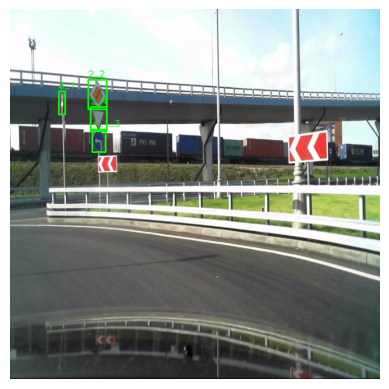

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 640, 640]) torch.Size([2, 4])
tensor([479.5000, 269.3333,  14.5000,  24.8889]) tensor(91)
tensor([497.5000, 266.6667,  16.0000,  28.4444]) tensor(16)


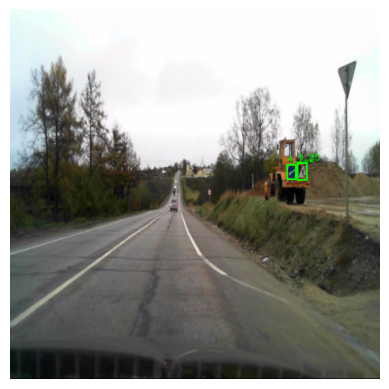

In [15]:
def denormalize(image_tensor, mean, std):
    """Обратная нормализация для отображения изображения"""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image_tensor * std + mean

def plot_with_boxes(image_tensor, bboxes, labels, mean, std, class_to_color, label_map_reverse):
    """Properly denormalize and visualize with bounding boxes"""
    print(type(image_tensor), type(bboxes))
    print(image_tensor.shape, bboxes.shape)
    # 1. Clone and detach tensor
    image = image_tensor.clone().detach().cpu()
    
    # 2. Denormalize
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean
    
    # 3. Convert to proper format for OpenCV
    image = image.mul(255).clamp(0, 255).permute(1, 2, 0).numpy()
    image = image.astype(np.uint8)
    image = np.ascontiguousarray(image[..., ::-1])  # RGB -> BGR
    
    # 4. Get image dimensions
    h, w = image.shape[:2]
    
    # 5. Draw boxes
    for box, label in zip(bboxes, labels):
        print(box, label)
        x_min, y_min, width, height = box.cpu().numpy()
        # Convert normalized to absolute coordinates
        x1 = int(x_min)
        y1 = int(y_min)
        x2 = int(x_min + width)
        y2 = int(y_min + height)
        
        # Get color and label
        class_id = label.item()
        color = (0, 255, 0)  # Default green
        class_name = label_map_reverse.get(class_id, str(class_id))
        
        # Draw rectangle (thickness=2)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        
        # Add label
        cv2.putText(
            image,
            class_name,
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            1,
            cv2.LINE_AA
        )
    
    # Convert back to RGB for matplotlib
    image = image[..., ::-1]
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Visualize sample
images, targets = next(iter(train_dataloader))
for i in range(len(images)):
    plot_with_boxes(
        images[i], 
        targets[i]["boxes"],
        targets[i]["labels"],
        mean,
        std,
        class_to_color,
        label_map_reverse
    )

In [16]:
# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, label='', color=(128, 128, 128), txt_color=(0, 0, 0), normalized=False):
    x_min, y_min, width, height = box
    
    if normalized:
        h, w = image.shape[:2]
        x1 = int(x_min * w)
        y1 = int(y_min * h)
        x2 = int((x_min + width) * w)
        y2 = int((y_min + height) * h)
    else:
        x1 = int(x_min)
        y1 = int(y_min)
        x2 = int(x_min + width)
        y2 = int(y_min + height)

    lw = int(max(round(sum(image.shape) / 2 * 0.003), 2))
    
    h, w = image.shape[:2]
    


    color = tuple(map(int, color))
    
    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness=lw, lineType=cv2.LINE_AA)

    if label:
        tf = max(lw - 1, 1)
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = y1 - h >= 3
        x2, y2 = x1 + w, y1 - h - 3 if outside else y1 + h + 3

        cv2.rectangle(image, (x1, y1), (x2, y2), color, -1, cv2.LINE_AA)
        cv2.putText(
            image,
            label,
            (x1, y1 - 2 if outside else y1 + h + 2),
            0,
            lw / 3,
            txt_color,
            thickness=tf,
            lineType=cv2.LINE_AA
        )

    return image

def plot_examples(df, mean, std, indices=None, num_examples=6, row_figsize=(12, 3)):
    if indices is None:
        indices = np.random.choice(len(df), size=num_examples, replace=False)
    else:
        num_examples = len(indices)

    ncols = min(num_examples, 3)
    nrows = math.ceil(num_examples / 3)
    
    _, axes = plt.subplots(nrows, ncols, figsize=(row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)

    for ix, ax in zip(indices, axes):
        row = df.iloc[ix]

        image = np.array(Image.open(io.BytesIO(row['image']['bytes'])))
        
        # Convert to BGR for OpenCV drawing
        image_bgr = image[..., ::-1].copy()
    
        bboxes = row["objects"]['bbox']
        classes = row["objects"]['category']
        
        for bbox, label in zip(bboxes, classes):
            color = class_to_color[label]
            class_name = label_map_reverse[label]
            img = add_bbox(image, bbox, label=str(class_name), color=color)

        # Convert back to RGB for matplotlib
        image_rgb = image_bgr[..., ::-1]
        ax.imshow(img)
        ax.set_title(f"Image id: {row['image_id']}")
        ax.set_xticks([])
        ax.set_yticks([])

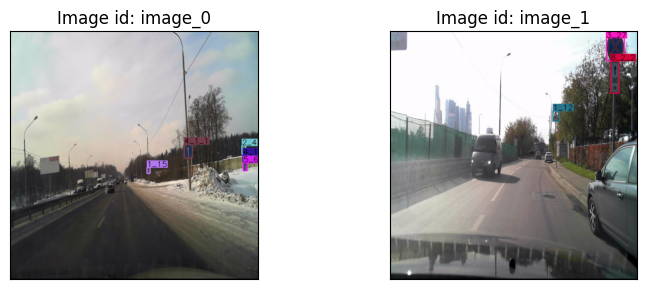

In [17]:
plot_examples(df_batch, mean, std, num_examples=min(batch_size, 8))

## Архитектура модели

### Backbone

In [18]:
class Backbone(nn.Module):
    def __init__(self, model_name="efficientnet_b5", out_indices=(-1, -2, -3), k=3):
        """
        Инициализация бэкбона.

        :param model_name: Имя модели из timm.
        :param out_indices: Индексы выходов, которые нужно вернуть.
        :param k: Количество последних слоев, которые нужно разморозить.
        """
        super(Backbone, self).__init__()
        self.out_indices = out_indices
        
        # Создание модели с использованием timm
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=self.out_indices)

        # Замораживаем все слои
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Размораживаем последние k слоев
        self.unfreeze_layers(k)

    def unfreeze_layers(self, k):
        """
        Размораживает последние k слоев модели.

        :param k: Количество слоев для разморозки.
        """
        layers = list(self.backbone.children())

        # Убедитесь, что k не превышает количество слоев
        if k > len(layers):
            k = len(layers)
            print(f'k задано больше, чем количество слоев модели, размораживаем все слои. k = {k}')

        # Размораживаем последние k слоев
        for layer in layers[-k:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, x):
        """
        Прямой проход через бэкбон.

        :param x: Входные данные (изображение).
        :return: Извлеченные признаки.
        """
        features = self.backbone(x)
        # Возвращаем только те выходы, которые указаны в out_indices
        return [features[i] for i in self.out_indices]

### Neck

In [19]:
class FPN(nn.Module):
    def __init__(self, in_channels, out_channels, num_levels):
        """
        Инициализация Feature Pyramid Network.

        :param in_channels: Список количества входных каналов для каждого уровня признаков.
        :param out_channels: Число выходных каналов для всех уровней.
        """
        super(FPN, self).__init__()

        # Убедитесь, что in_channels — это список или кортеж
        if isinstance(in_channels, int):
            in_channels = [in_channels]  # Превращаем в список, если это int
        
        # Латеральные свертки для каждой пирамиды
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(in_ch, out_channels, kernel_size=1) for in_ch in in_channels
        ])

        # Свертки для объединения фичей
        self.fpn_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1) for _ in range(len(in_channels))
        ])

    def forward(self, features):
        """
        Прямой проход через Feature Pyramid Network.

        :param features: Список признаков из различных уровней (например, из бэкбона).
        :return: Список агрегированных признаков.
        """
        # Латеральные связи
        laterals = [conv(feat) for conv, feat in zip(self.lateral_convs, features)]

        # Объединение признаков
        for i in range(len(laterals) - 1, 0, -1):
            laterals[i - 1] += nn.functional.interpolate(laterals[i], size=laterals[i - 1].shape[2:], mode='nearest')

        # Применение сверток FPN
        out_features = [conv(laterals[i]) for i, conv in enumerate(self.fpn_convs)]

        return out_features

### Head

In [20]:
class DecoupledHead(nn.Module):
    def __init__(self, in_channels, num_classes, num_anchors):
        """
        Инициализация Decoupled Head для YOLOX.

        :param in_channels: Количество входных каналов.
        :param num_classes: Число классов для классификации.
        :param num_anchors: Число якорей.
        """
        super(DecoupledHead, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors

        print(f"DecoupledHead - in_channels: {in_channels}, num_classes: {num_classes}, num_anchors_per_cell: {num_anchors}")

        # Полносвязные слои для классификации
        self.cls_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, num_classes * num_anchors, kernel_size=1, stride=1)
        )

        # Полносвязные слои для регрессии
        self.reg_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, 5 * num_anchors, kernel_size=1, stride=1)  # 5 координаты для bbox
        )

    def forward(self, x):
        """
        Прямой проход через Decoupled Head.

        :param x: Входные данные (признаки из Neck).
        :return: Классификационные и регрессионные выходы.
        """
        cls_out = self.cls_layer(x)
        reg_out = self.reg_layer(x)

        return cls_out, reg_out

### Detector

In [21]:
class Detector(nn.Module):
    def __init__(
        self,
        backbone_name,
        num_classes,
        out_channels,
        anchor_sizes,
        anchor_ratios,
        input_size
    ):
        super(Detector, self).__init__()
        
        self.backbone = Backbone(model_name=backbone_name)

                
        in_channels = self.backbone.backbone.feature_info.channels()
        self.input_size = input_size
        self.num_classes = num_classes

        self.fpn = FPN(in_channels=in_channels, out_channels=out_channels, num_levels=len(in_channels))
        
         # Генерируем якоря
        self.anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
        
        # Узнаем размер выходной фичемапы
        reductions = self.backbone.backbone.feature_info.reduction()[:len(in_channels)]
        self.grid_sizes = [[input_size[0] // r, input_size[1] // r] for r in reductions]

        # Расчитываем координаты якорей в каждой точке выходной фичемапы.
        # Якоря хранятся в формате (x_min, y_min, x_max, y_max)!
        strides = [[r, r] for r in reductions]
        print(f"Grid sizes: {self.grid_sizes}, Strides: {strides}")
        anchors = self.anchor_generator.grid_anchors(self.grid_sizes, strides=strides)
        self.num_anchors_per_level = [len(anchors_per_level) for anchors_per_level in anchors]
        num_anchors_per_cell = len(anchor_sizes[0]) * len(anchor_ratios[0])

        anchors = torch.cat(anchors, dim=0)  # Concatenate anchors from all levels

        # Заранее считаем координаты якорей в формате (x_center, y_center, w, h)
        # Это пригодится для расчета лосса
        anchor_centers = (anchors[:, :2] + anchors[:, 2:]) / 2
        anchor_sizes = (anchors[:, 2:] - anchors[:, :2])

        print("Anchor min/max:", torch.min(anchors), torch.max(anchors))  # Should be ~0 to 1

        print(self.num_anchors_per_level, sum(self.num_anchors_per_level))

        self.register_buffer("anchors", anchors)
        self.register_buffer("anchor_centers", anchor_centers)
        self.register_buffer("anchor_sizes", anchor_sizes)

        self.head = DecoupledHead(in_channels=out_channels, num_classes=num_classes, num_anchors=num_anchors_per_cell)
        
    def forward(self, x):
        N = x.shape[0]
        
        features = self.backbone(x)
        neck_features = self.fpn(features)
        
        # Обрабатываем каждый уровень FPN отдельно
        all_cls_logits = []
        all_bbox_preds = []
        for feat in neck_features:
            cls_logits, bbox_preds = self.head(feat)
            # Reshape directly to (batch_size, num_anchors_per_level, num_classes) or (batch_size, num_anchors_per_level, 5)
            cls_logits = cls_logits.permute(0, 2, 3, 1).reshape(x.size(0), -1, self.num_classes)
            cls_logits = cls_logits.view(N, -1, self.head.num_classes) # [N, NUM_ANCHORS * W * H, NUM_CLASSES]
            bbox_preds = bbox_preds.permute(0, 2, 3, 1).reshape(x.size(0), -1, 5)
            bbox_preds = bbox_preds.view(N, -1, 5) # [N, NUM_ANCHORS * W * H, 5]
            all_cls_logits.append(cls_logits)
            all_bbox_preds.append(bbox_preds)

        # Объединяем предсказания по пространственным измерениям
        cls_logits = torch.cat(all_cls_logits, dim=1)
        bbox_preds = torch.cat(all_bbox_preds, dim=1)
        
        bbox_offsets = bbox_preds[:, :, :4]
        confidence_logits = bbox_preds[:, :, 4]

        if self.training:
            # В процессе тренировки возвращаем просто смещения и логиты
            return bbox_offsets, confidence_logits, cls_logits

        # Для предсказания декодируем боксы для каждого уровня FPN
        bboxes = []
        start_idx = 0
        for i, grid_size in enumerate(self.grid_sizes):  # grid_sizes should be stored as an instance variable
            num_anchors = self.num_anchors_per_level[i]
            level_bbox_offsets = bbox_offsets[:, start_idx:start_idx + num_anchors, :]
            level_bbox_offsets = bbox_offsets[:, :num_anchors, :]  # Ensure correct slicing
            level_bboxes = self.decode_bboxes(level_bbox_offsets, grid_size, level_idx=i)  # Pass level index
            bboxes.append(level_bboxes)
            start_idx += num_anchors

        # Если мы делаем предсказание, сразу считаем итоговый ббокс и вероятности
        # Модель предсказывает ббоксы в формате (x_min, y_min, w, h)
        bboxes = torch.cat(bboxes, dim=1)
        confidence = torch.sigmoid(confidence_logits)
        cls_probs = torch.softmax(cls_logits, dim=-1)
        return bboxes, confidence, cls_probs

    def decode_bboxes(self, bbox_reg, grid_size, level_idx):
        """Используя предсказанные смещения, считаем предсказанные ббоксы по формулам из YOLOv3.

        Боксы возвращаются в формате YOLO.
        """
        tx = bbox_reg[:, :, 0]
        ty = bbox_reg[:, :, 1]
        tw = bbox_reg[:, :, 2]
        th = bbox_reg[:, :, 3]

        # Get anchors for this level only
        start_idx = sum(self.num_anchors_per_level[:level_idx])
        end_idx = start_idx + self.num_anchors_per_level[level_idx]
        level_anchors = self.anchor_centers[start_idx:end_idx]  # shape: [num_anchors_in_level, 2]
        level_sizes = self.anchor_sizes[start_idx:end_idx]      # shape: [num_anchors_in_level, 2]
        
        # Calculate shifts (ensure shapes match)
        center_x_shift = torch.sigmoid(tx) * grid_size[1]  # [batch_size, num_anchors]
        center_y_shift = torch.sigmoid(ty) * grid_size[0]
        
        # Calculate centers (broadcast correctly)
        center_x = level_anchors[None, :, 0] + center_x_shift  # [1, num_anchors] + [batch_size, num_anchors]
        center_y = level_anchors[None, :, 1] + center_y_shift
    
        w = torch.exp(tw) * level_sizes[:, 0]
        h = torch.exp(th) * level_sizes[:, 1]

        x_min = center_x - w / 2
        y_min = center_y - h / 2

        return torch.stack([x_min, y_min, w, h], dim=-1)

## Label assignment

In [22]:
def safe_logit(x):
    """ Безопасный расчет logit'ов. """
    eps = 1e-6
    x = torch.clamp(x, eps, 1 - eps)
    return torch.log(x / (1 - x))


def get_target_offset(anchor_box, gt_box):
    """ Рассчитываем таргет как желаемые смещения от якорей до GT.
    anchor_box and gt_box: torch.Tensor in format (x_min, y_min, x_max, y_max), normalized [0, 1].
    """
    # Конвертируем GT в формат (x_center, y_center), (w, h)
    gt_center = (gt_box[:2] + gt_box[2:]) / 2
    gt_size = gt_box[2:] - gt_box[:2]

    # Конвертируем якоря в формат (x_center, y_center), (w, h)
    anchor_center = (anchor_box[:2] + anchor_box[2:]) / 2
    anchor_size = anchor_box[2:] - anchor_box[:2]

    # Calculate normalized offsets
    tx = (gt_center[0] - anchor_center[0]) / anchor_size[0]
    ty = (gt_center[1] - anchor_center[1]) / anchor_size[1]
    tw = gt_size[0] / anchor_size[0]
    th = gt_size[1] / anchor_size[1]

    target_tx = safe_logit(tx)
    target_ty = safe_logit(ty)

    target_tw = torch.log(gt_size[0] / anchor_size[0])
    target_th = torch.log(gt_size[1] / anchor_size[1])

    # print("target", [target_tx.item(), target_ty.item(), target_tw.item(), target_th.item()])
    return torch.tensor([target_tx, target_ty, target_tw, target_th]).to(anchor_box.device)

In [31]:
def assign_target(image, anchors, gt_boxes, gt_labels, num_classes, pos_th=0.6, neg_th=0.3):
    """ Для каждого GT находим якоря, которые будут участвовать в расчете лосса по следующему алгоритму:
    1. Положительные якоря - якоря у которых IoU с GT >= `pos_th`,
    2. Игнорируемые якоря - `neg_th` <= IoU c GT < `pos_th`,
    3. Отрицательные якоря - IoU c GT < `neg_th`.
    4. Если для GT не нашлось ни одного якоря, назначаем GT якорь с самым большим IoU.

    Параметры
    ---------
    anchors : list[list[float]]
        Набор якорей для выходной фичемапы, размер (NUM_ANCHORS * W * H, 4)
    gt_boxes : list[list[float]]
        Набор истинных ббоксов на изображении, размер (N_GT, 4)
    gt_labels : list[int]
        Набор лейблов для GT, размер (N_GT, )
    num_classes : int
        Количество классов в датасете
    pos_th : float
        Минимальная граница по IoU между якорем и GT после которой якорь считается положительным.
    neg_th : float
        Верхняя граница по IoU между якорем и GT когда якорь считается отрицательным.

    Returns
    -------
    target_offsets: Массив, содержащий истинные смещения для положительных якорей, 0 для всех остальных
    target_objectness: Массив, содержащий тип каждого якоря (1 - положительный, 0 - отрицательный, -1 - игнорируемый)
    target_cls: Массив, содержащий ohe классы для каждого якоря. Для всех, кроме положительных якорей, класс не указан.
    """
    num_anchors = anchors.shape[0]
    target_objectness = torch.zeros(num_anchors, device=anchors.device)
    target_offsets = torch.zeros((num_anchors, 4), device=anchors.device)
    target_cls = torch.zeros((num_anchors, num_classes), device=anchors.device)

    # Если на изображении нет объектов, возвращаем пустые списки
    if gt_boxes.numel() == 0:
        return target_offsets, target_objectness, target_cls

    # box_iou работает с форматом ббоксов (x_min, y_min, x_max, y_max)
    # Якоря находятся в нужном формате, а GT - нет, тк имеет формат (x_min, y_min, w, h)
    # Переведем GT боксы в нужный формат
    gt_xyxy = gt_boxes.clone()
    gt_xyxy[:, 2:] = gt_xyxy[:, :2] + gt_xyxy[:, 2:]

    # Считаем iou между всеми якорями и всеми GT
    ious = box_iou(anchors, gt_xyxy) # [num_anchors, num_gt]
    # Находим самый оптимальный GT для каждого якоря
    best_iou, best_gt_idx = ious.max(dim=1)

    # Отмечаем якоря, которые будут пропущены при расчете лосса
    ignore_mask = (best_iou >= neg_th) & (best_iou < pos_th)
    ignore_indices = ignore_mask.nonzero(as_tuple=True)[0]
    target_objectness[ignore_mask] = -1

    # Отмечаем якоря, для которых будет считаться локализационный лосс
    pos_mask = best_iou >= pos_th
    pos_indices = pos_mask.nonzero(as_tuple=True)[0]
    
    # Отмечаем якоря, для которых будет считаться конфиденс лосс
    neg_mask = best_iou < pos_th
    neg_indices = neg_mask.nonzero(as_tuple=True)[0]

    # print("Number of gt:", len(gt_xyxy))
    # print("Positive anchors:", len(pos_indices))
    # print("Negative anchors:", len(neg_indices))
    # print("Ignored anchors:", len(ignore_indices))
    # print("Max IoU:", best_iou.max().item(), "Mean IoU:", best_iou.mean().item())
    if torch.isnan(best_iou.max()):
        print("-"*50)
        print(gt_xyxy)
        nan_indices = torch.where(torch.isnan(best_iou))
        print("nan_indices", nan_indices)
        print("nan_anchors", anchors[nan_indices])
        print([(x2 - x1, y2 - y1) for x1, y1, x2, y2 in anchors[nan_indices].tolist()])
        
    for pos in pos_indices:
        gt_idx = best_gt_idx[pos]
        gt_box = gt_xyxy[gt_idx]
        anchor_box = anchors[pos]

        target_offsets[pos] = get_target_offset(anchor_box, gt_box)
        target_objectness[pos] = 1
        target_cls[pos, gt_labels[gt_idx]] = 1
        
        anchor_box[2] = anchor_box[2] - anchor_box[0]
        anchor_box[3] = anchor_box[3] - anchor_box[1]

        boxes = torch.cat((gt_boxes, anchor_box[None, :]), axis=0)
        labels = [gt_labels[gt_idx.item()]]*len(boxes)
        
        # plot_with_boxes(image, boxes, labels, mean, std, class_to_color, label_map_reverse)

    # Присваиваем предсказание с самым большим IoU для GT
    # у которых не нашлось ни оного предсказания
    for gt_idx in range(gt_xyxy.shape[0]):
        if not((target_objectness == 1) & (best_gt_idx == gt_idx)).any():
            best_anchor_idx = torch.argmax(ious[:, gt_idx])
            target_offsets[best_anchor_idx] = get_target_offset(anchors[best_anchor_idx], gt_xyxy[gt_idx])
            target_objectness[best_anchor_idx] = 1
            target_cls[best_anchor_idx, gt_labels[gt_idx]] = 1

    return target_offsets, target_objectness, target_cls

### Функция потерь

In [32]:
class ComputeLoss:
    """ Базовый расчет лосса.

    Параметры
    ---------
    bbox_loss : Локализационная часть лосса
    obj_loss : Лосс для Confidence score
    cls_loss : Классификационная часть лосса
    weight_bbox, weight_obj, weight_cls : Константы для балансировки частей лосса
    """
    def __init__(self, bbox_loss=None, obj_loss=None, cls_loss=None, weight_bbox=5, weight_obj=1, weight_cls=1):
        self.bbox_loss = nn.SmoothL1Loss() if bbox_loss is None else bbox_loss
        self.obj_loss = nn.BCEWithLogitsLoss() if obj_loss is None else obj_loss
        self.cls_loss = nn.BCEWithLogitsLoss() if cls_loss is None else cls_loss
        self.weight_bbox = weight_bbox
        self.weight_obj = weight_obj
        self.weight_cls = weight_cls

    def __call__(self, predicts, targets):
        """ Расчет лосса для пары (предсказание, таргет)

        Параметры
        ---------
        predicts : Предсказания модели для одной картинки: Смещения, objectness score и логиты для классов
        targets : Gt значения для расчета лосса, а именно: GT смещения, GT objectness score и GT ohe классы
        """
        pred_offsets, pred_obj_logits, pred_cls_logits = predicts
        target_boxes, target_obj, target_cls = targets

        # Add nan checks
        if torch.isnan(pred_obj_logits).any():
            print("NaN in objectness logits!")
            print("Min:", pred_obj_logits.min().item(), "Max:", pred_obj_logits.max().item())
            pred_obj_logits = torch.nan_to_num(pred_obj_logits, nan=0.0)
        
        # Confidence score считается только для предсказаний соотв отрицательным и положительным якорям
        valid_mask = target_obj != -1
        if valid_mask.sum() == 0:
            loss_obj = torch.tensor(0.0, device=pred_obj_logits.device)
        else:
            loss_obj = self.obj_loss(pred_obj_logits[valid_mask], target_obj[valid_mask])

        # Локализационная и классификационные части считаются для предсказаний, соответствующих положительным якорям
        pos_mask = target_obj == 1
        if pos_mask.sum() > 0:
            # print("pred_offsets has NaN:", torch.isnan(pred_offsets).any())
            # print("target_boxes has NaN:", torch.isnan(target_boxes).any())
            # print("pred_offsets[pos_mask] has NaN:", torch.isnan(pred_offsets[pos_mask]).any())
            # print("target_boxes[pos_mask] has NaN:", torch.isnan(target_boxes[pos_mask]).any())
            # print(target_boxes[pos_mask])
            loss_cls = self.cls_loss(pred_cls_logits[pos_mask], target_cls[pos_mask])
            loss_bbox = self.bbox_loss(pred_offsets[pos_mask], target_boxes[pos_mask])
        else:
            loss_cls = torch.tensor(0.0, device=pred_offsets.device)
            loss_bbox = torch.tensor(0.0, device=pred_offsets.device)

        return self.weight_bbox * loss_bbox + self.weight_obj * loss_obj + self.weight_cls * loss_cls

## Обучение детектора

In [33]:
class Runner:
    """ Базовый класс для обучения и валидации модели.

    Параметры
    ---------
    model : torch модель, которая будет обучаться.
    compute_loss : экземпляр класса ComputeLoss (или другого с реализованным методом __call__).
    optimizer : torch optimizer
    train_dataloader : torch dataloader семплирующий данные для обучения модели.
    assign_target_method : callable, который решает задачу сопоставления якорей и таргета (например, assign_target)
    deivce : девайс на котором будет происходить обучения, по дефолту "cpu"
    scheduler : torch scheduler
    assign_target_kwargs : доп параметры для функции в `assign_target_method`,
    val_dataloader : torch dataloader загружающий валидационные данные.
    score_threshold : При расчете метрики на валидации, все предсказания,
        с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.
    """
    def __init__(
        self,
        model,
        compute_loss,
        optimizer,
        train_dataloader,
        assign_target_method,
        device=None,
        scheduler=None,
        assign_target_kwargs=None,
        val_dataloader=None,
        val_every=5,
        score_threshold=0.1,
        nms_threshold=0.5,
        max_boxes_per_cls=8
    ):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        assign_target_kwargs = {} if assign_target_kwargs is None else assign_target_kwargs
        self.assign_target_method = partial(assign_target_method, **assign_target_kwargs)
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        # Валидационные параметры
        self.val_dataloader = val_dataloader
        self.val_every = val_every
        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls

        # Вспомогательные массивы
        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []

    def _run_train_epoch(self, dataloader, verbose=True):
        """ Обучить модель одну эпоху на данных из `dataloader` """
        self.model.train()
        batch_loss = []
        for images, targets in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            outputs = self.model(images)
            anchors = self.model.anchors.view(-1, 4)
            accum_loss = 0.0
            for ix in range(images.shape[0]):
                gt_boxes = targets[ix]['boxes'].to(self.device)
                gt_labels = targets[ix]['labels'].to(self.device)
                # выбираем какие якоря будут использоваться при расчете лосса.
                assigned_targets = self.assign_target_method(images[ix], anchors, gt_boxes, gt_labels,
                                                             num_classes=model.num_classes)

                # Считаем лосс на основании предсказаний модели и таргетов.
                outputs_ixs = [out[ix] for out in outputs]
                loss = self.compute_loss(outputs_ixs, assigned_targets)
                if torch.isnan(loss):
                    print(loss)
                accum_loss += loss
            accum_loss = accum_loss / images.shape[0]
            batch_loss.append(accum_loss.cpu().detach().item())

            # Делаем шаг оптимизатора после расчета лосса для всех элементов батча
            self.optimizer.zero_grad()
            accum_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add this line
            self.optimizer.step()
        # Обновляем описание tqdm бара усредненным значением лосса за предыдущй батч
            if verbose:
                pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4}")
        
        return batch_loss

    def train(self, num_epochs=10, verbose=True):
        """ Обучаем модель заданное количество эпох. """
        val_desc = ""
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))

            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                val_metric = self.validate()
                self.val_metric.append(val_metric)
                val_desc = f" Val {val_metric:.4}"

            # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.4}" + val_desc)
            # Делаем шаг scheduler'a если он был передан
            if self.scheduler is not None:
                self.scheduler.step()


    @torch.no_grad()
    def validate(self, dataloader=None):
        """ Метод для валидации модели. Если dataloader не передан, будет использоваться self.val_dataloder.
        Возвращает mAP (0.5 ... 0.95).
        """
        self.model.eval()

        dataloader = self.val_dataloader if dataloader is None else dataloader

        # Считаем метрику mAP с помощью функции из torchmetrics
        metric = MeanAveragePrecision(box_format="xywh", iou_type="bbox")

        for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
            images = images.to(self.device)
            outputs = self.model(images)
            predicts = _filter_predictions(
                outputs,
                self.score_threshold,
                self.nms_threshold,
                max_boxes_per_cls=self.max_boxes_per_cls,
                return_type="torch"
            )
            metric.update(predicts, targets)

        plot_predictions(images, predicts)

        return metric.compute()["map"].item()

    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue")
        ax[0].plot(np.arange(1, len(self.batch_loss)+1, len(self.train_dataloader)), self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss")
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Iterations")
        ax[0].set_ylabel("Loss")
        if self.val_metric:
            ax[1].plot(np.arange(self.val_every, len(self.batch_loss)+1, len(self.val_dataloader) * self.val_every),
                       np.array(self.val_metric) * 100, color="tab:green", label="Validation mAP")
            ax[1].grid()
            ax[1].set_title("Valiation mAP")
            ax[1].set_xlabel("Number of Iterations")
            ax[1].set_ylabel("mAP (%)")
        plt.legend()
        plt.show()

def _filter_predictions(predictions, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type="list"):
    """ Ббоксы в `predictions` должны быть в формате (x_min, y_min, w, h). """
    # Итоговый скор считается как произведение уверенности модели в том что в данном якоре
    # и вероятность каждого класса в данном якоре.
    bboxes, confidences, cls_probs = predictions
    all_final_scores = confidences[:, :, None] * cls_probs

    num_classes = cls_probs.shape[-1]
    final_predictions = []
    # Для каждого элемента в `predictions` независимо выбираем ббоксы и скоры
    for boxes, final_scores in zip(bboxes, all_final_scores):
        preds = {"boxes": [], "labels": [], "scores": []}

        # Для каждого класса отдельно фильтруем ббоксы с помощью NMS
        for cls in range(num_classes):
            cls_scores = final_scores[:, cls]
            # Фильтруем ббоксы, score которых меньше порога
            keep_ixs = cls_scores > score_threshold
            if keep_ixs.sum() == 0:
                continue
            cls_boxes = boxes[keep_ixs]
            cls_scores = cls_scores[keep_ixs]

            # Если предсказаний слишком много, выбираем только самые уверенные
            if len(cls_boxes) > max_boxes_per_cls:
                pos = torch.argsort(cls_scores, descending=True)
                cls_boxes = cls_boxes[pos[:max_boxes_per_cls]]
                cls_scores = cls_scores[pos[:max_boxes_per_cls]]

            # Конвертируем ббоксы в формат x_min, y_min, x_max, y_max
            boxes_xyxy = cls_boxes.clone()
            boxes_xyxy[:, 2:] = boxes_xyxy[:, :2] + boxes_xyxy[:, 2:]
            # Запускаем NMS по всем оставшимся ббоксам класса cls
            pred_ixs = nms(boxes_xyxy, cls_scores, nms_threshold)
            # Сохраняем все предсказания для класса cls
            for ix in pred_ixs:
                preds["boxes"].append(cls_boxes[ix].cpu().tolist())
                preds["labels"].append(cls)
                preds["scores"].append(cls_scores[ix].item())
        if return_type == "torch":
            for key, item in preds.items():
                preds[key] = torch.tensor(item)
        elif return_type != "list":
            raise ValueError(f"Received unexpected `return_type`. Could be either `torch` or `list`, not {return_type}")
        final_predictions.append(preds)
    return final_predictions

In [34]:
# Calculate mean width/height of GT boxes
all_widths = []
all_heights = []
for images, targets in tqdm(train_dataset):
    for i in range(images.shape[0]):
        boxes = targets['boxes']
        all_widths.extend(boxes[:, 2].tolist())
        all_heights.extend(boxes[:, 3].tolist())

mean_w = np.mean(all_widths)
mean_h = np.mean(all_heights)
print(f"Mean GT box size: {mean_w:.1f}x{mean_h:.1f} pixels")

from sklearn.cluster import KMeans

# Perform k-means clustering
gt_sizes = np.array([[w, h] for w, h in zip(all_widths, all_heights)])
kmeans = KMeans(n_clusters=3, random_state=0).fit(gt_sizes)
cluster_centers = kmeans.cluster_centers_  # Shape: (5, 2)

# Extract base sizes (e.g., average of width and height from each cluster)
base_sizes = np.mean(cluster_centers, axis=1).tolist()  # Average width and height as base size
base_sizes = tuple((int(x), ) for x in base_sizes)

# Define aspect ratios (same for all sizes)
aspect_ratios = ((0.5, 0.7, 0.9, 1.2, 1.5, 1.7, 1.9, 2.1), ) * len(base_sizes)  # Single set of ratios for all levels (adjust if using FPN)

  0%|          | 0/300 [00:00<?, ?it/s]

Mean GT box size: 19.7x34.0 pixels


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [41]:
lr = 1e-3
model = Detector(
    "efficientnet_b0",
    num_classes=len(label_map),
    anchor_sizes=base_sizes,
    anchor_ratios=aspect_ratios,
    input_size=(img_width, img_height),
    out_channels=256
).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-5)

smooth_l1_loss = nn.SmoothL1Loss()
bce_loss = nn.BCEWithLogitsLoss()
compute_loss = ComputeLoss(smooth_l1_loss, bce_loss, bce_loss, weight_bbox=5, weight_obj=1, weight_cls=2)

runner = Runner(
    model,
    compute_loss,
    optimizer,
    train_dataloader,
    assign_target,
    device=device,
    scheduler=scheduler,
    assign_target_kwargs={"neg_th":0.4, "pos_th":0.6},
    val_dataloader=train_dataloader,
    val_every=1,
    score_threshold=0.1,
    
)

num_epochs = 10


Grid sizes: [[20, 20], [40, 40], [80, 80]], Strides: [[32, 32], [16, 16], [8, 8]]
Anchor min/max: tensor(-43.) tensor(675.)
[3200, 12800, 51200] 67200
DecoupledHead - in_channels: 256, num_classes: 155, num_anchors_per_cell: 8


In [50]:
def plot_predictions(images, predictions, figsize=(12, 3)):
    """ Рисуем по 3 предсказания на одной строке. """
    
    ncols = min(len(images), 3)
    for ix in range(0, len(images), ncols):
        _, axes = plt.subplots(1, ncols, figsize=figsize, tight_layout=True)
        if ncols == 1:
            axes = [axes]
        for i, (ax, img) in enumerate(zip(axes, images[ix: ix+ncols])):
            img = img.cpu().permute(1, 2, 0).numpy()
            img = img * np.array(std).reshape(1, 1, -1) + np.array(mean).reshape(1, 1, -1)
            img = np.ascontiguousarray((img * 255).astype(np.uint8))
            preds = predictions[ix + i]
            for bbox, label, score in zip(preds["boxes"], preds["labels"], preds["scores"]):
                if isinstance(label, torch.Tensor):
                    label = label.item()
                color = class_to_color[label]
                label = label_map_reverse[label]
                img = add_bbox(img, bbox, label=f"Class {label}: {score:.2f}", color=color)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    plt.close()

In [43]:
torch.cuda.empty_cache()
gc.collect()
print(torch.cuda.memory_allocated())  # Память, выделенная для тензоров
print(torch.cuda.memory_reserved()) 

0
0


Train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

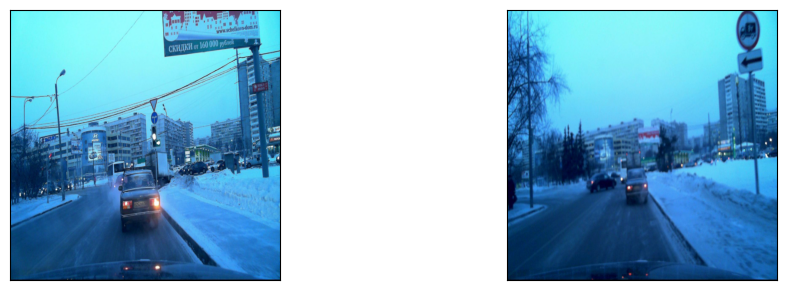

Process train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

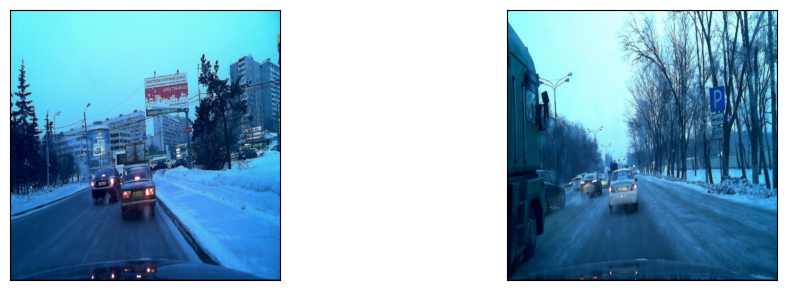

Process train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

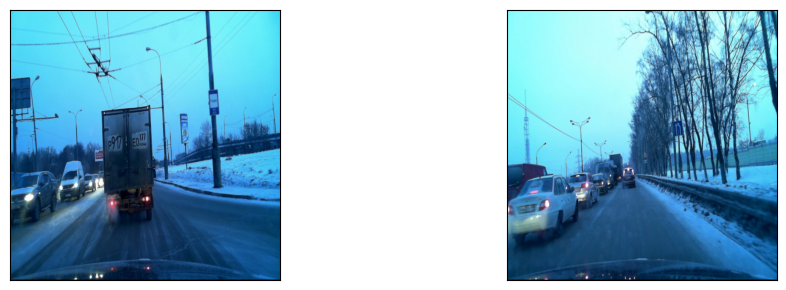

Process train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

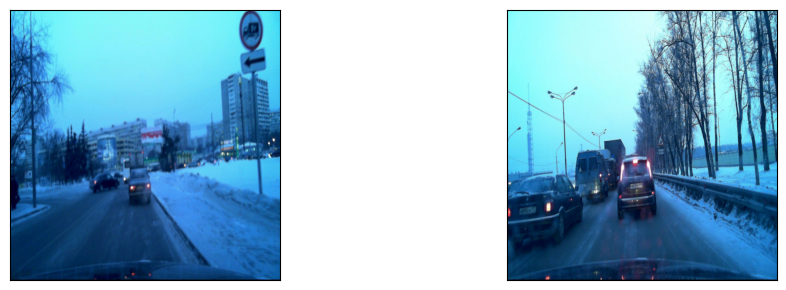

Process train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

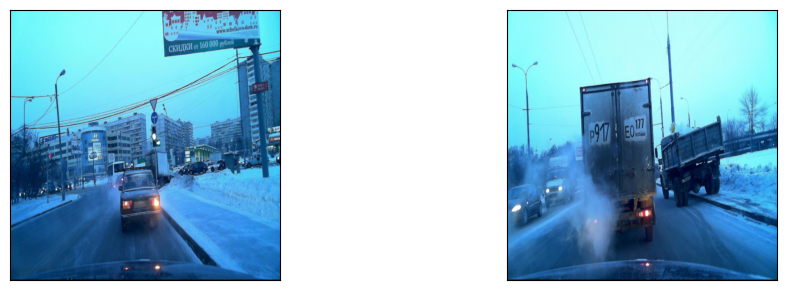

Process train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

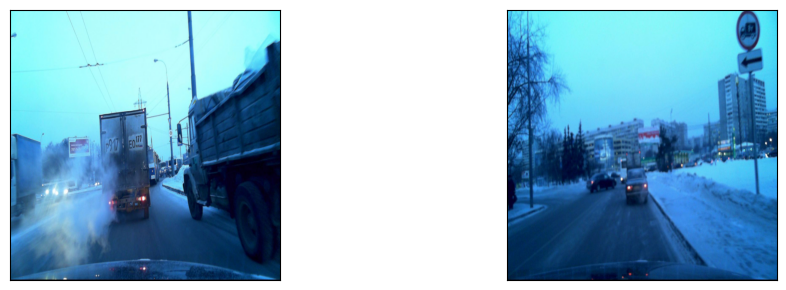

Process train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

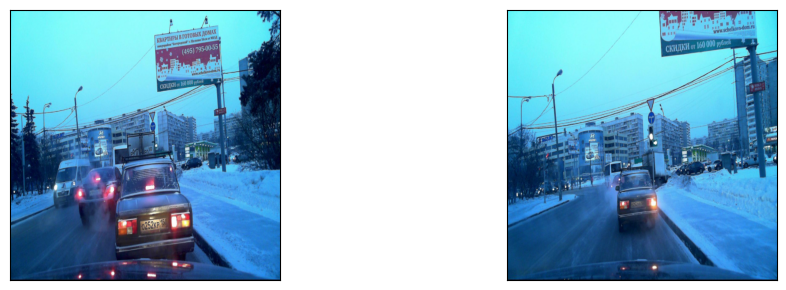

Process train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

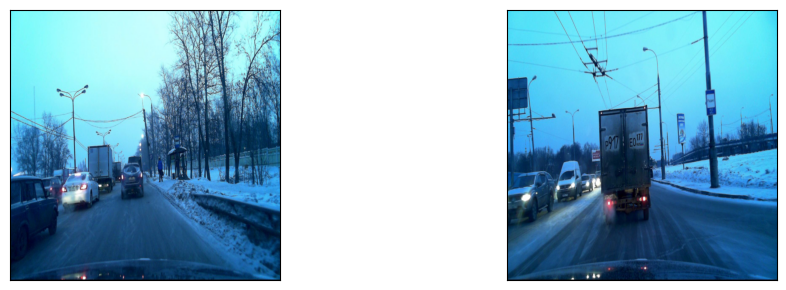

Process train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

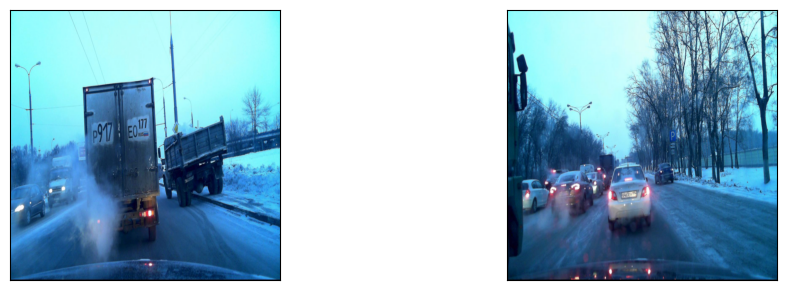

Process train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

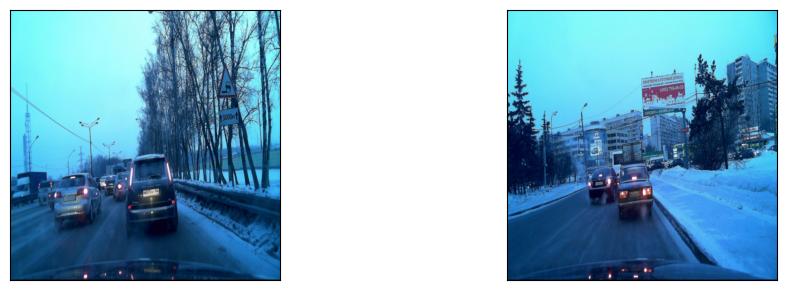

In [44]:
runner.train(num_epochs=num_epochs, verbose=True)

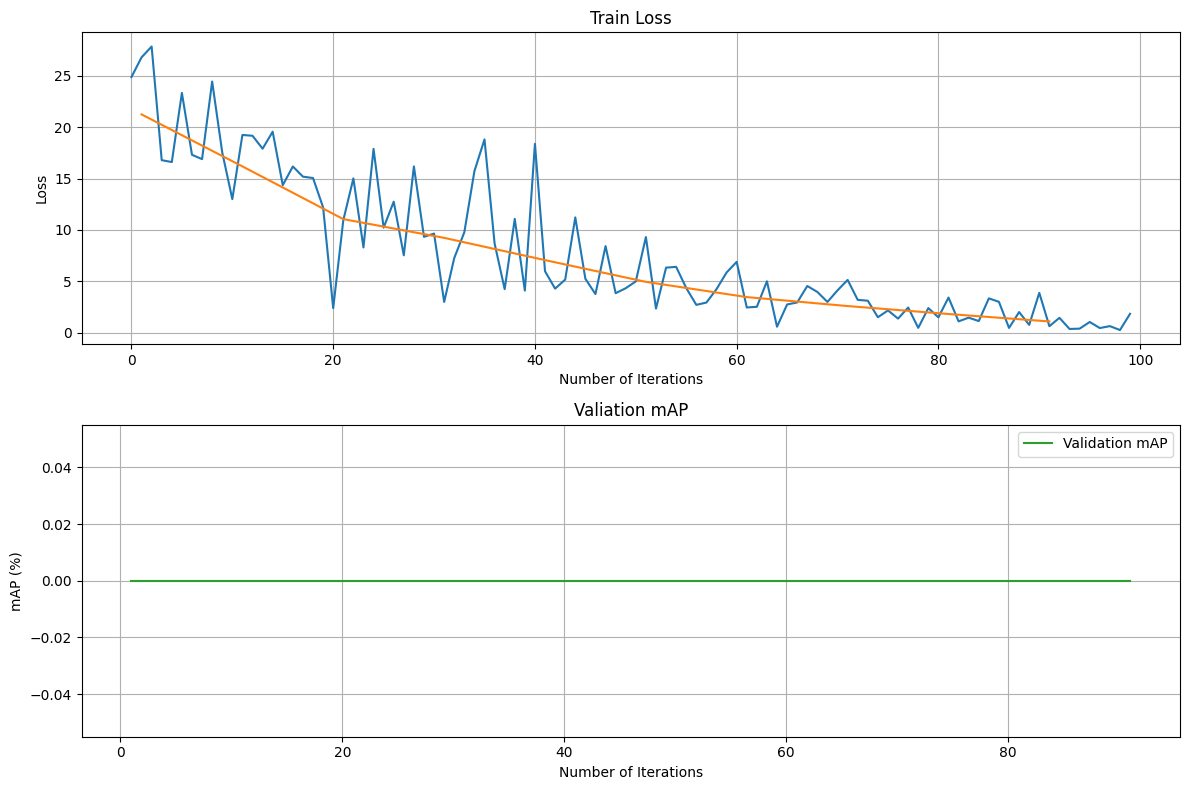

In [45]:
runner.plot_loss(row_figsize=4)

In [46]:
from torchmetrics.detection import MeanAveragePrecision

@torch.no_grad()
def validate(dataloader, filter_predictions_func, box_format="xyxy", device="cpu", score_threshold=0.1, nms_threshold=0.5, **kwargs):
    """ Метод для валидации модели.
    Возвращает mAP (0.5 ... 0.95).
    """
    self.model.eval()
    # Считаем метрику mAP с помощью функции из torchmetrics
    metric = MeanAveragePrecision(box_format=box_format, iou_type="bbox")
    for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
        images = images.to(device)
        outputs = self.model(images)
        predicts = filter_predictions_func(outputs, score_threshold, nms_threshold, **kwargs)
        metric.update(predicts, targets)
    return metric.compute()["map"].item()


In [47]:
@torch.no_grad()
def predict(model, images, device, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type='list'):
    """ Предсказание моделью для переданного набора изображений после фильтрации по score_threshold
    и применения NMS.

    Параметры
    --------
    images : torch.tensor, содержащий картинки для которых нужно сделать предсказание.
    Необходимые преобразования должны быть сделаны ДО. Внутри метода `predict` никаких преобразований
    не происходит.
    score_threshold : Все предсказания, с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.

    Returns
    -------
    final_predictions : List[dict], где каждый словарь содержащий следующие ключи:
        "boxes" : координаты ббоксов на i-ом изображении,
        "labels" : классы внутри ббоксов,
        "scores" : Confidence scores для ббоксов.
    """
    model.eval()
    images = images.to(device)
    outputs = model(images)
    final_predictions =  _filter_predictions(outputs, score_threshold=score_threshold, nms_threshold=nms_threshold,
                                             max_boxes_per_cls=max_boxes_per_cls, return_type=return_type)
    return final_predictions

In [48]:
test_iter = iter(train_dataloader)  # test_dataloader

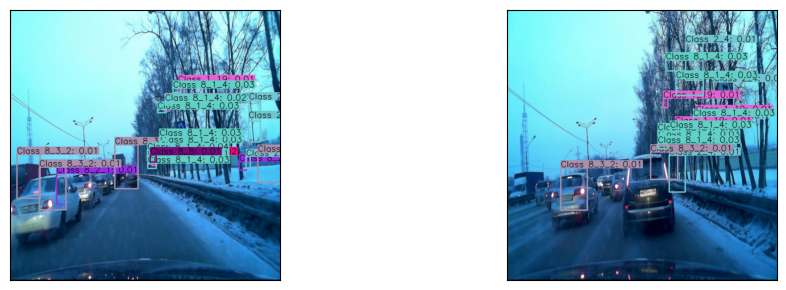

In [52]:
score_threshold = 0.01
nms_threshold = 0.1

images, _ = next(test_iter)
preds = predict(model, images, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)
plot_predictions(images, preds)

Running validation:   0%|          | 0/10 [00:00<?, ?it/s]

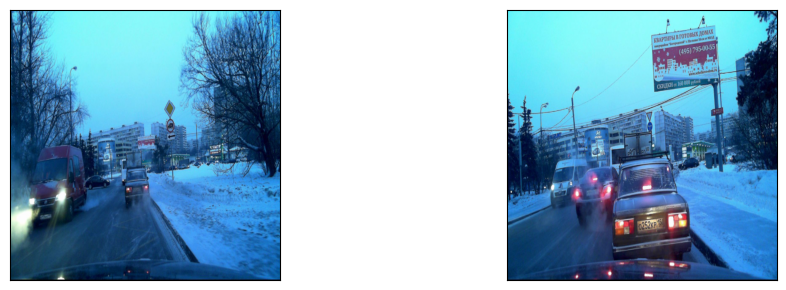

Final mAP: 0.0


In [53]:
print("Final mAP:", runner.validate())